# CSPB 3022 Spring 2022 Project: Regression Analysis

## Nishey Wanchoo

### Explanation
This project is a regression analysis of the Auto MPG Data set from the UCI Machine Learning Repository. I recently swapped in my combustion vehicle for an EV to try and reduce my carbon footprint. 
### Data Description
This dataset is a multi-variate dataset with various attributes of a car and their respective miles per gallon. Several continuous variables that can be used to analyze for correlation and predicting the value of miles per gallon using the other variables, or a combination of those variables. There are 398 rows and 9 columns of data from the csv file, for a file size of 18090 bytes. 

### Motivation
I selected the longer range option and was surpised that although the the long range car is heavier (presumably with a bigger battery pack), it has the same mpge as the standard range option. I assume there is a different technology to improve the efficiency of the long range model. This made me curious what the data looked like for combustion vehicles. 


### Resources used:
    
https://archive.ics.uci.edu/ml/datasets/Auto+MPG

https://realpython.com/linear-regression-in-python/
    
https://datatofish.com/correlation-matrix-pandas/
    
https://www.w3schools.com/python/python_ml_polynomial_regression.asp

https://devenum.com/how-to-find-index-of-value-in-pandas-dataframe/#:~:text=To%20find%20the%20indexes%20of,Math'%20in%20the%20Subject%20column.

https://datatofish.com/replace-values-pandas-dataframe/

### Data Cleaning and EDA
There were 6 entries in the horsepower column which had question marks, and therefore an analysis could not be run on teh horespower data. I replaced those with the horsepower average. Alternatively, those rows could have been removed from the data set but there did not seem to be much impact to the correlation values of HP to MPG with or without those. I opted to substitute for the average so more data could be included in the other correlations. In this analysis, Miles Per Gallon (mpg), was correlated against the other continuous numeric variables (weight, displacement, horsepower, and acceleration). The manfuacturing year, origin, and cyclinder are discrete numeric variables and weren't used for regression analysis. There is also a column for car_name. Those may be more appopriate for a classification analysis. I suspected that the miles per gallon will go down as weight increases. I also supsected that weight, horse power, and displacement are all positively correlated (heavier cars will have larger engines with more horse power and volumetric displacement). I assumed cars with more acceleration will have more horsepower, and therefore more weight. So I suspected this will also be negatively correlated.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
%matplotlib inline 
import scipy.stats
import scipy.stats.kde
import numpy as np
import pandas as pd
import seaborn as sn
import os
import statsmodels.formula.api as smf
import statsmodels.api as sm

df = pd.read_csv('auto-mpg_data.csv')
ind = df[df.hp=='?'].index
#drop non-continuous data
df = df.drop(['cyl','yr','origin','car_name'],axis = 1)
#swap out data which has ? with average horsepower data, convert everyhting from an object to numeric for analysis
df2 = df[df.hp!='?']
df2['hp'] = pd.to_numeric(df2['hp'])
hp_avg = df2.hp.mean()
ind = df[df.hp=='?'].index
df['hp'] = df['hp'].replace(['?'],str(hp_avg))
df['hp'] = pd.to_numeric(df['hp'])


/var/folders/x6/f0q8n2qj1dj7f13gqpslb8kw0000gn/T/ipykernel_47693/2810789414.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['hp'] = pd.to_numeric(df2['hp'])


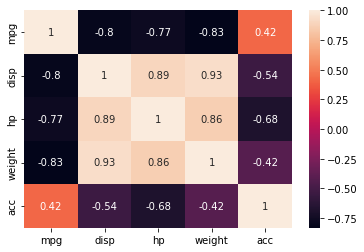

In [2]:
corrMatrix = df.corr()
#plt.figure(figsize = (10,10))
sn.heatmap(corrMatrix, annot=True)
plt.show()

### EDA continued

A correlation analysis was performed to assess what, if anything, was highly correlated with mpg. That could be used for predicting the mpg in the regression analysis.

Note that the correlation matrix is symmetric about the diagonal. The variables that are highly correlated (positive) are closer to beige, while the variables that are highly correlated (negative) are closer to black. Those variables closer to red, orange, and purple, have a weaker correlation with each other. Based on the heat map, we can look at the Miles Per Gallon row (or column) and see that displacement, horsepower and weight all have a strong negative correlation. This means the higher the higher the displacement, horsepower, weight, the lower the miles per gallon. Of the three highly negatively correlated variables, weight has the highest correlation. Given the high / similar negative correlations between those three variables and MPG, we would expect a strong positive correlation between the three variables. We can see that's true as the variables all have strong correlations. The acceleration is actually moderately positively correlated with miles per gallon. This is not in line with what I suspected initially.

Now we will look at the actual data sets and visualize the weight vs mpg, horsepower vs mpg, displacement vs mpg, and acceleration vs mpg

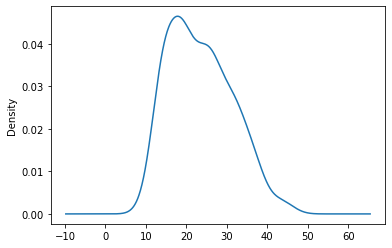

In [3]:
ax = df.mpg.plot.kde() #kernel density estimate of mpg. Similar code below for continuous data

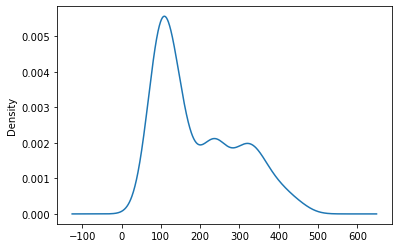

In [4]:
ax = df.disp.plot.kde()

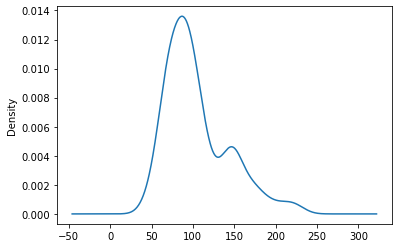

In [5]:
ax = df.hp.plot.kde()

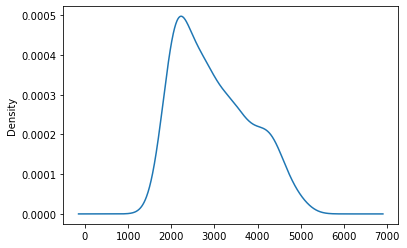

In [6]:
ax = df.weight.plot.kde()

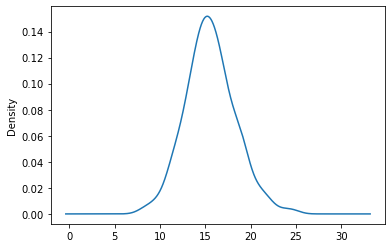

In [7]:
ax = df.acc.plot.kde()

As can be seen, the distributions of all the variables except acceleration are multi-modal. 

Next we will plot the different independent variables against dependent variable, MPG. It's always valuable to visualize the data to see if a pattern may be discernable rather than just perform a linear regression.

Text(0, 0.5, 'MPG')

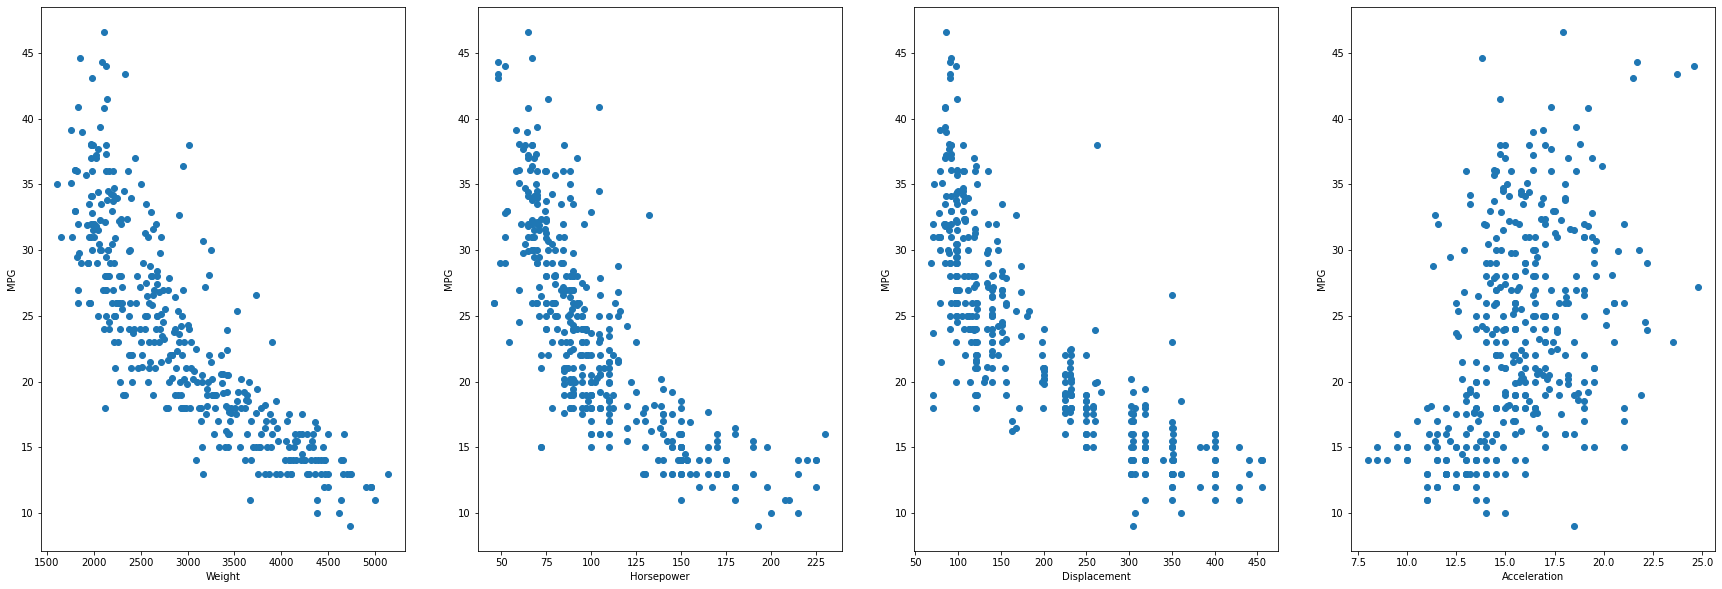

In [8]:
#plotting potential predictor variables against dependent variable
plt.figure(figsize = (30,10))
plt.subplot(1,4,1)
plt.scatter(df.weight,df.mpg)
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.subplot(1,4,2)
plt.scatter(df.hp,df.mpg)
plt.xlabel('Horsepower')
plt.ylabel('MPG')
plt.subplot(1,4,3)
plt.scatter(df.disp,df.mpg)
plt.xlabel('Displacement')
plt.ylabel('MPG')
plt.subplot(1,4,4)
plt.scatter(df.acc,df.mpg)
plt.xlabel('Acceleration')
plt.ylabel('MPG')


### Simple model

My first linear regression was using the car weight as a predictor of MPG. 

Looking at the data, it appears the weight is quadratically related to the MPG. I will assess that in future analysis. There are some slightly higher MPG values near the 3000 - 3500 lb weight, but I don't believe those are outliers and shouldn't impact the model significantly. For future analysis, I can look at a leverage plot to help identify any points that may have an outsized influence on the regression.

In [9]:
from sklearn.linear_model import LinearRegression
weight = np.array(df.weight).reshape(-1,1)
mpg = np.array(df.mpg)
#linear regression of weight vs miles per gallon, with slope and intercept saved as variables below
model = LinearRegression().fit(weight,mpg)
slope = model.coef_
intercept = model.intercept_
#rsquared and correlation calculations
r_sq = model.score(weight, mpg)
r_sq
corr = r_sq**.5
print('The correlation of weight to MPG is %.4f, and the R-squared is %.4f' % (corr, corr**2))

The correlation of weight to MPG is 0.8317, and the R-squared is 0.6918


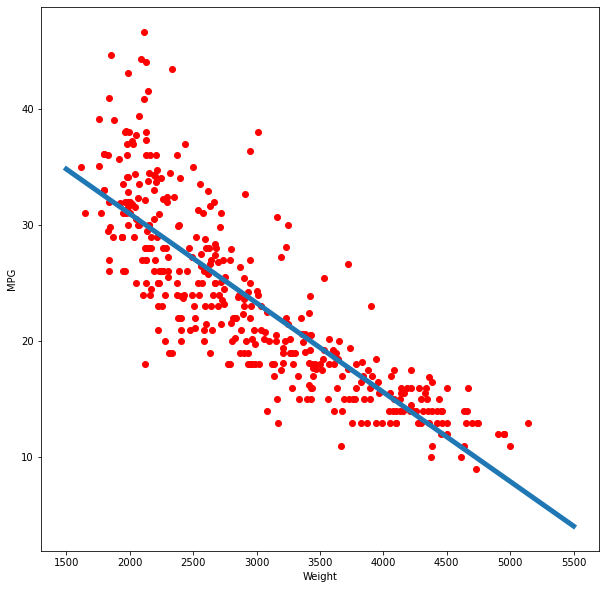

In [10]:
#plot of regression line against actual data
plt.figure(figsize = (10,10))
plt.plot(weight,mpg, 'ro')
x_ticks = np.linspace(1500, 5500, 10)
plt.plot(x_ticks, intercept + slope*x_ticks, lw = 5)
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.show()

Given how strongly the correlated the weight, displacement, and horespower are, I don't ancitipate a multi-linear regression will improve the predictive powers of the model much. I investigate further below.  

In [11]:
X1 = df[['weight', 'hp', 'disp', 'acc']]
y = df['mpg']

X2 = df[['weight', 'hp', 'disp']]
X3  = df[['weight', 'hp', 'acc']]
X4  = df[['hp', 'disp', 'acc']]

X5  = df[['weight', 'hp']]
X6  = df[['weight', 'disp']]
X7  = df[['weight', 'acc']]

X8  = df[['hp', 'disp']]
X9  = df[['hp', 'acc']]

X10  = df[['disp', 'acc']]

model1 = LinearRegression().fit(X1,y)
model2 = LinearRegression().fit(X2,y)
model3 = LinearRegression().fit(X3,y)
model4 = LinearRegression().fit(X4,y)
model5 = LinearRegression().fit(X5,y)
model6 = LinearRegression().fit(X6,y)
model7 = LinearRegression().fit(X7,y)
model8 = LinearRegression().fit(X8,y)
model9 = LinearRegression().fit(X9,y)
model10 = LinearRegression().fit(X10,y)

r_sq1 = model1.score(X1, y)
r_sq2 = model2.score(X2, y)
r_sq3 = model3.score(X3, y)
r_sq4 = model4.score(X4, y)
r_sq5 = model5.score(X5, y)
r_sq6 = model6.score(X6, y)
r_sq7 = model7.score(X7, y)
r_sq8 = model8.score(X8, y)
r_sq9 = model9.score(X9, y)
r_sq10 = model10.score(X10, y)


print('Multi-linear R-squared values: %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f, %.4f' % (r_sq1, r_sq2, r_sq3, r_sq4, r_sq5, r_sq6, r_sq7, r_sq8, r_sq9, r_sq10))


Multi-linear R-squared values: 0.7045, 0.7045, 0.7038, 0.6699, 0.7037, 0.6980, 0.6983, 0.6606, 0.6169, 0.6471


In [12]:
#forward stepwise selection of predictors 
est = smf.ols('mpg ~ weight', df).fit() #adj r2 = .691
est.summary()

est = smf.ols('mpg ~ hp', df).fit() #adj r2 = .594
est.summary()

est = smf.ols('mpg ~ disp', df).fit() #adj r2 = .647
est.summary()

est = smf.ols('mpg ~ acc', df).fit() #adj r2 = .175
est.summary()

#weight is best, so I will keep that as first predictor

est = smf.ols('mpg ~ weight+hp', df).fit() #adj r2 = .702
est.summary()

est = smf.ols('mpg ~ weight+disp', df).fit() #adj r2 = .692
est.summary()

est = smf.ols('mpg ~ weight+acc', df).fit() #adj r2 = .697
est.summary()

#horsepower is next best predictor along with weight. So that will be my second predictor

est = smf.ols('mpg ~ weight+hp+disp', df).fit() #adj r2 = .702
est.summary()

est = smf.ols('mpg ~ weight+hp+acc', df).fit() #adj r2 = .702
est.summary()

#displacement is next best predictor, so that is appended on

est = smf.ols('mpg ~ weight+hp+disp+acc', df).fit() #adj r2 = .702
est.summary()
#all predictors in model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     234.3
Date:                Sun, 01 May 2022   Prob (F-statistic):          1.26e-102
Time:                        15:36:43   Log-Likelihood:                -1140.0
No. Observations:                 398   AIC:                             2290.
Df Residuals:                     393   BIC:                             2310.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     44.9503      2.418     18.589      0.000      40.196      49.704
weight        -0.0054      0.001     -6.787      0.000      -0.007      -0.004
hp            -0.0376      0.016     -2.346      0.019      -0.069      -0.006
disp          -0.0068      0.007     -1.012      0.312      -0.020       0.006
acc           -0.0022      0.123     -0.018      0.986      -0.243       0.239
==============================================================================
Omnibus:                       38.209   Durbin-Watson:                   0.842
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.354
Skew:                           0.713   Prob(JB):                     1.16e-11
Kurtosis:                       4.000   Cond. No.                     3.50e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Multi-linear regression analysis

Using a forward stepwise selection, we can see the R_squared value does not increase appreciably as we add more variables other than weight as a predictor. Therefore, a single predictor value is the model I would select for a single-order linear fit.


As mentioned above, although the correlation between MPG and weight is strong, the plot appears quadratic in nature. The next step I will take is to fit a second order polynomial to the data to try and improve the R-squared.

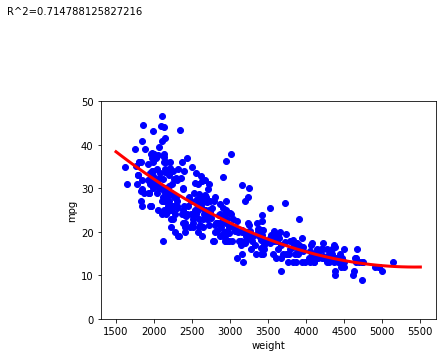

In [13]:
from sklearn.preprocessing import PolynomialFeatures
#second order polynomial regression of weight vs mpg
X = PolynomialFeatures(2).fit_transform(df.weight.values.reshape(-1,1))
ss = sm.OLS(df.mpg, X).fit()
plt.plot(df.weight, df.mpg, 'bo');
xticks = np.linspace(1500,5500)
plt.plot(xticks, np.polynomial.polynomial.polyval(xticks,ss.params), 'r', lw=3)
plt.ylim(0,50)
plt.xlabel('weight');
plt.ylabel('mpg');
plt.text(70,70,'R^2=' + str(ss.rsquared))
plt.show()

Even with a quadratic fit, the R-squared value only increases from 0.691 to 0.715

Next we will look for interaction effects. I followed a similar method as the forward stepwise selection above, starting with weight since it had the highest R-squared value. 

In [14]:
#follow the same process as forward stepwise selection above, except looking for interaction terms. 
#Starting off with weight from the beginning since that had best correlation based on last results

est = smf.ols('mpg ~ weight*hp', df).fit() #adj r2 = .740, F-stat = 378.5
est.summary()

est = smf.ols('mpg ~ weight*disp', df).fit() #adj r2 = .724, F-stat = 348.4
est.summary()

est = smf.ols('mpg ~ weight*acc', df).fit() #adj r2 = .702, F-stat = 312.9
est.summary()

#horsepower is next best, with weight
est = smf.ols('mpg ~ weight*hp*disp', df).fit() #adj r2 = .748, F-stat = 169.4
est.summary()

est = smf.ols('mpg ~ weight*hp*acc', df).fit() #adj r2 = .742, F-stat = 164.4
est.summary()

#displacement is next best, assuming weight and horsepower are already in the model

est = smf.ols('mpg ~ weight*hp*disp*acc', df).fit() #adj r2 = .759, F-stat = 84.28
est.summary()

est = smf.ols('mpg ~ weight*hp', df).fit() #adj r2 = .740, F-stat = 378.5
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     378.5
Date:                Sun, 01 May 2022   Prob (F-statistic):          1.22e-115
Time:                        15:36:43   Log-Likelihood:                -1112.7
No. Observations:                 398   AIC:                             2233.
Df Residuals:                     394   BIC:                             2249.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     63.1158      2.364     26.701      0.000      58.469      67.763
weight        -0.0108      0.001    -13.832      0.000      -0.012      -0.009
hp            -0.2375      0.027     -8.736      0.000      -0.291      -0.184
weight:hp   5.133e-05   6.67e-06      7.692      0.000    3.82e-05    6.45e-05
==============================================================================
Omnibus:                       37.545   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.372
Skew:                           0.621   Prob(JB):                     1.28e-13
Kurtosis:                       4.427   Cond. No.                     4.77e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.77e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Although the R-squared value is maximized by having a dependence between all the variables, I also see that weight * horsepower has a relatively close R-squared value with a high F-statistic. In an attempt of not overfitting the model, I will opt for the simpler model with fewer predictors

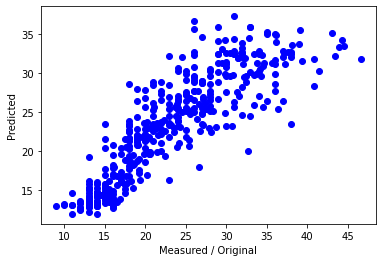

In [15]:
#plot of actual data vs predicted data. Ideally all data lies along the diagonal with a slope of 1, indicating a perfect model
plt.plot(df.mpg, est.predict(df), 'bo');
plt.xlabel('Measured / Original')
plt.ylabel('Predicted');

Ideally, the data would follow a straight line. We can see that around 23 - 25 mpg, the data becomes more divergent from the perfect predictor line.

In [16]:
import patsy
from sklearn import datasets
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import linear_model,metrics

Next I perform a cross-validation of the model mpg = weight * hp with 3 groups.

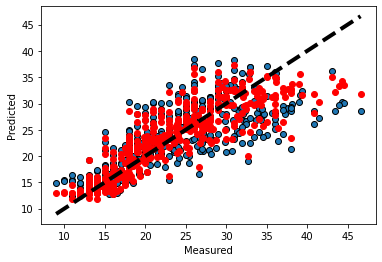

In [17]:
auto_mpg, auto_weightXhp = patsy.dmatrices('mpg ~ weight*hp', data=df) #map the data so that it can be used for cross-validation
auto_lr = linear_model.LinearRegression()


auto_predicted = cross_val_predict(auto_lr, auto_weightXhp, auto_mpg, cv=3) #cross-validation with three groups/sets
auto_lgest = smf.ols('mpg ~ weight*hp', df).fit()
#plot data
fig, ax = plt.subplots()
plt.plot(df.mpg, auto_lgest.predict(df), 'ro');
ax.scatter(df.mpg, auto_predicted, edgecolors=(0, 0, 0))
ax.plot([df.mpg.min(), df.mpg.max()], [df.mpg.min(), df.mpg.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [18]:
auto_mpg, auto_weight_x_hp = patsy.dmatrices('mpg ~ weight*hp', data=df)
auto_lr = linear_model.LinearRegression()


auto_predicted = cross_val_predict(auto_lr, auto_weight_x_hp, auto_mpg, cv=3)
auto_lgest = smf.ols('mpg ~ weight*hp', df).fit()
#print out regular score (R^2) and cross-validation scores with the weight * hp model 
print('R^2 for non-cross-over model is', auto_lgest.rsquared)
print('Cross validation scores are', cross_val_score(auto_lr, auto_weight_x_hp, auto_mpg, cv=3))



R^2 for non-cross-over model is 0.7424149671381512
Cross validation scores are [ 0.31822366  0.7630479  -0.03070892]


Although the model has a decent R-squared, we can see from the cross-validation that the model isn't great for the low and high ends of the model. I'll see if I can improve the R-squared value and the cross-validation performance by linearizing the data by taking the log of mpg vs log of weight * horsepower.

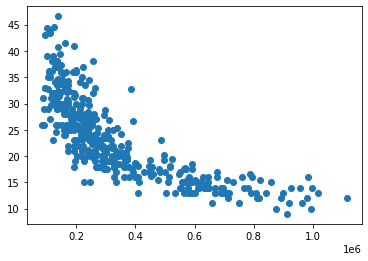

In [19]:
plt.scatter(df.weight*df.hp, df.mpg)

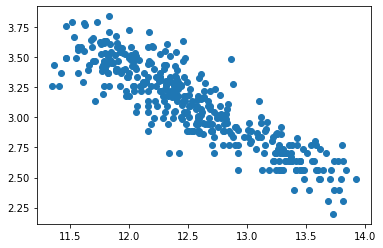

In [20]:
plt.scatter(np.log(df.weight*df.hp), np.log(df.mpg)) #visualize linearization of data

As we can see, the taking the logs improved the linear relationship between mpg and weight * horsepower. Now that we have linearized the model, we can see if the R-squared and cross-validation R^2 improved

In [21]:
#repeat cross-validation with new model

auto_mpg, auto_weight_x_hp = patsy.dmatrices('np.log(mpg) ~ np.log(weight*hp)', data=df)
auto_lr = linear_model.LinearRegression()


auto_predicted = cross_val_predict(auto_lr, auto_weight_x_hp, auto_mpg, cv=3)
auto_lgest = smf.ols('np.log(mpg) ~ np.log(weight*hp)', df).fit()

print('R^2 for non-cross-over model is', auto_lgest.rsquared)
print('Cross validation scores are', cross_val_score(auto_lr, auto_weight_x_hp, auto_mpg, cv=3))

R^2 for non-cross-over model is 0.7863139406182804
Cross validation scores are [ 0.62696629  0.75898458 -0.02544325]


The R^2 for the full model has increased by linearizing the model by applying a log scaling to the data. The cross-data score for the lower end is much better, but the high end is still pretty poor.

In [22]:
#repeat cross-validation with tweaked model
auto_mpg, auto_weight_x_hp = patsy.dmatrices('np.log(mpg) ~ np.log(weight)*np.log(hp)', data=df)
auto_lr = linear_model.LinearRegression()


auto_predicted = cross_val_predict(auto_lr, auto_weight_x_hp, auto_mpg, cv=3)
auto_lgest = smf.ols('np.log(mpg) ~ np.log(weight)*np.log(hp)', df).fit()

print('R^2 for non-cross-over model is', auto_lgest.rsquared)
print('Cross validation scores are', cross_val_score(auto_lr, auto_weight_x_hp, auto_mpg, cv=3))

R^2 for non-cross-over model is 0.7949072186536428
Cross validation scores are [ 0.58604137  0.77386958 -0.05582946]


Making a small tweak to the model so that log(mpg) ~ log(weight) * log(horsepower) rather than log(mpg) ~ log(weight * horsepower) improves the overall R^2 for the full data set slightly. It also increases the middle and high end data set in the cross-model validation but the low end data is score is reduced. Although the high end score is improved, it is still pretty poor.

## Conclusion


After completing the EDA clean up and initial analysis, I performed a regression analysis. I began with a forward stepwise selection process. I noted that even with all predictors included, the R-squared didn't seem to increase much. Therefore, weight alone was a decent predictor for a data sample as a whole. I then noted that visually, the mpg vs weight data looked quadratic, so I tried to do a second-order (quadratic) polynomial fit. This increased the R-squared, but not by much. Next, I looked for any interaction effects. I followed a similar approach as the forward stepwise selection process, adding one new predictor variable at each step. There the R-squared did increase more. Although the interaction of all foure predictor variables leads to the highest R-squared value, it may lead to overfitting of the data. Therefore, I chose the top interaction pair of mpg ~ weight * horsepower. This had a reasonably higher R-squared than just the single mpg ~ weight comparison, without adding too much complexity.

After defining the model as mpg ~ weight * horsepower, I performed a cross-validation and plotted the measured data against the predicted data (train + test). The model doesn't seem to hold up well in the lower and upper boundaries of the data. This was confirmed by looking at the cross-validation scores. It can be observed that the cross-validation model does poorly particularly in the 3rd fold of the data.

Re-looking at the model I chose, I realized that the model may improve by linearizing the model. It seemed to follow a log function, so I took the log of (weight * horsepower) as my new model. A subsequent cross-validation showed the model worked better on the initial data set but still struggled with the third tranche of cross-validation data. I attempted to make a small tweak so the linearized model was log(mpg) ~ log(weight) * log(horsepower). This only slightly improved the model on the last set of cross-validation data, but it also mildly dropped the score of the first set of data. 

Given that I wasn't able to get a model that performed well on all sets of data when cross-validation was performed, I think this model might improve for with a piecewise regression. Doing a piecewise regression may help account for any "steps" in the data. Although no step is totally obvious, I think the model may improve if we look at the data as two different chunks with a different regression model for 0 - 0.5e6 and another model for 0.5e6 - 1.5e6.